In [1]:
!pip install datasets
!pip install matplotlib
import torch
import torch.nn as nn
from torchvision import transforms, models
from torch.profiler import record_function
from datasets import load_dataset
import time
import numpy as np
import matplotlib.pyplot as plt

# set seed for reproducibility in torch, numpy and gpu

torch.manual_seed(710)
np.random.seed(710)

  Using cached datasets-3.2.0-py3-none-any.whl.metadata (20 kB)
  Using cached pyarrow-19.0.0-cp310-cp310-manylinux_2_28_x86_64.whl.metadata (3.3 kB)
  Using cached dill-0.3.8-py3-none-any.whl.metadata (10 kB)
  Using cached xxhash-3.5.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (12 kB)
  Using cached multiprocess-0.70.16-py310-none-any.whl.metadata (7.2 kB)
  Using cached aiohttp-3.11.12-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (7.7 kB)
  Using cached aiohappyeyeballs-2.4.6-py3-none-any.whl.metadata (5.9 kB)
  Using cached aiosignal-1.3.2-py2.py3-none-any.whl.metadata (3.8 kB)
  Using cached async_timeout-5.0.1-py3-none-any.whl.metadata (5.1 kB)
  Using cached frozenlist-1.5.0-cp310-cp310-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (13 kB)
  Using cached multidict-6.1.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (5.0 kB)
  Using cached propcache-0.2.1-cp310-

In [2]:
tiny_imagenet = load_dataset("Maysee/tiny-imagenet", split="train")
tiny_imagenet[0]

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=64x64>,
 'label': 0}

In [3]:
# get number of classes
num_classes = len(tiny_imagenet.features["label"].names)
num_classes

200

In [4]:
# get number of cuda devices available
torch.cuda.device_count()

2

- For purposes of this experiment, we are going to use one GPU first

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [6]:
# Convert to torch dataset

class TinyImageNet(torch.utils.data.Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        x, y = self.dataset[idx]["image"], self.dataset[idx]["label"]
        # convert x to RGB
        x = x.convert("RGB")
        if self.transform:
            x = self.transform(x)
        y = torch.tensor(y, dtype=torch.int64)
        return x, y

# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

tiny_imagenet_torch = TinyImageNet(tiny_imagenet, transform=transform)
type(tiny_imagenet_torch[0])

tuple

### Load model to GPU

In [7]:
torch.cuda.memory._record_memory_history(
       max_entries=10000
   )

model_gpu_usage_before = torch.cuda.memory_allocated(device)
model = models.resnet18(pretrained=True)
model.to(device)

model_gpu_usage_after = torch.cuda.memory_allocated(device)

model_gpu_usage = model_gpu_usage_after - model_gpu_usage_before

# print number of parameters in the model

print(f"Number of parameters in the model: {sum(p.numel() for p in model.parameters())}")
print(f"Model GPU usage: {model_gpu_usage / 1024**2:.2f} MB")

del model


/root/miniconda3/envs/py3.10/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/root/miniconda3/envs/py3.10/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Number of parameters in the model: 11689512
Model GPU usage: 44.69 MB


### Compare effect of checkpointing on memory usage for large batch sizes

In [8]:
def fit(model, train_loader, val_loader, epochs=1, lr=0.001, break_after_num_batches=None, title=""):
    model.train()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = torch.nn.CrossEntropyLoss()


    with torch.profiler.profile(
        activities=[torch.profiler.ProfilerActivity.CPU, torch.profiler.ProfilerActivity.CUDA],
        schedule=torch.profiler.schedule(wait=0, warmup=0, active=6, repeat=1),
        record_shapes=True,
        with_stack=True,
        profile_memory=True
    ) as prof:

        for epoch in range(epochs):
            for batch_idx, batch in enumerate(train_loader):
                prof.step()


                inputs, labels = batch
                
                with record_function("to_device"):
                    inputs, labels = inputs.to(device), labels.to(device)

                with record_function("forward"):
                    outputs = model(inputs)
                
                with record_function("backward"):
                    criterion(outputs, labels).backward()
                
                with record_function("optimizer_step"):
                    optimizer.step()
                    optimizer.zero_grad()


                if break_after_num_batches is not None and batch_idx >= break_after_num_batches:
                    break

                

    prof.export_memory_timeline(f"{title}_memory.html", device="cuda:0")

    

def clear_cuda_memory():
    # Clear memory caches
    torch.cuda.empty_cache()
    
    # Reset peak memory stats
    torch.cuda.reset_peak_memory_stats()
    
    # Clear memory allocated by PyTorch
    torch.cuda.synchronize()
    
    # Optional: Force garbage collection
    import gc
    gc.collect()
    
    # Print memory stats to verify
    print(f"Allocated memory: {torch.cuda.memory_allocated() / 1024**2:.2f} MB")
    print(f"Cached memory: {torch.cuda.memory_reserved() / 1024**2:.2f} MB")

def fit_helper(model_type, dataset, epochs, break_after_num_batches, title):
    for batch_size in batch_sizes:
        if model_type == "resnet18_without_checkpointing":
            model = models.resnet18(pretrained=True)
        elif model_type == "resnet18_with_checkpointing":
            model = ResnetCheckpointed()
        model.to(device)
        train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
        val_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
        title += f"_{batch_size}"
        oom_break = False

        try:
            fit(model, train_loader, val_loader, epochs=1, break_after_num_batches=break_after_num_batches)
            print(f"Proccessed for batch size {batch_size}")
        except torch.cuda.OutOfMemoryError:
            print(f"Out of memory for batch size {batch_size}")
            oom_break = True
        # clear memory
        del model
        del train_loader
        del val_loader
        clear_cuda_memory()
        time.sleep(10)
        if oom_break:
            break

/root/miniconda3/envs/py3.10/lib/python3.10/site-packages/torch/profiler/profiler.py:406: UserWarning: Profiler won't be using warmup, this can skew profiler results
  warn("Profiler won't be using warmup, this can skew profiler results")


Proccessed for batch size 256
Allocated memory: 16.25 MB
Cached memory: 318.00 MB
Proccessed for batch size 512
Allocated memory: 16.25 MB
Cached memory: 318.00 MB
Out of memory for batch size 1024
Allocated memory: 16.25 MB
Cached memory: 318.00 MB


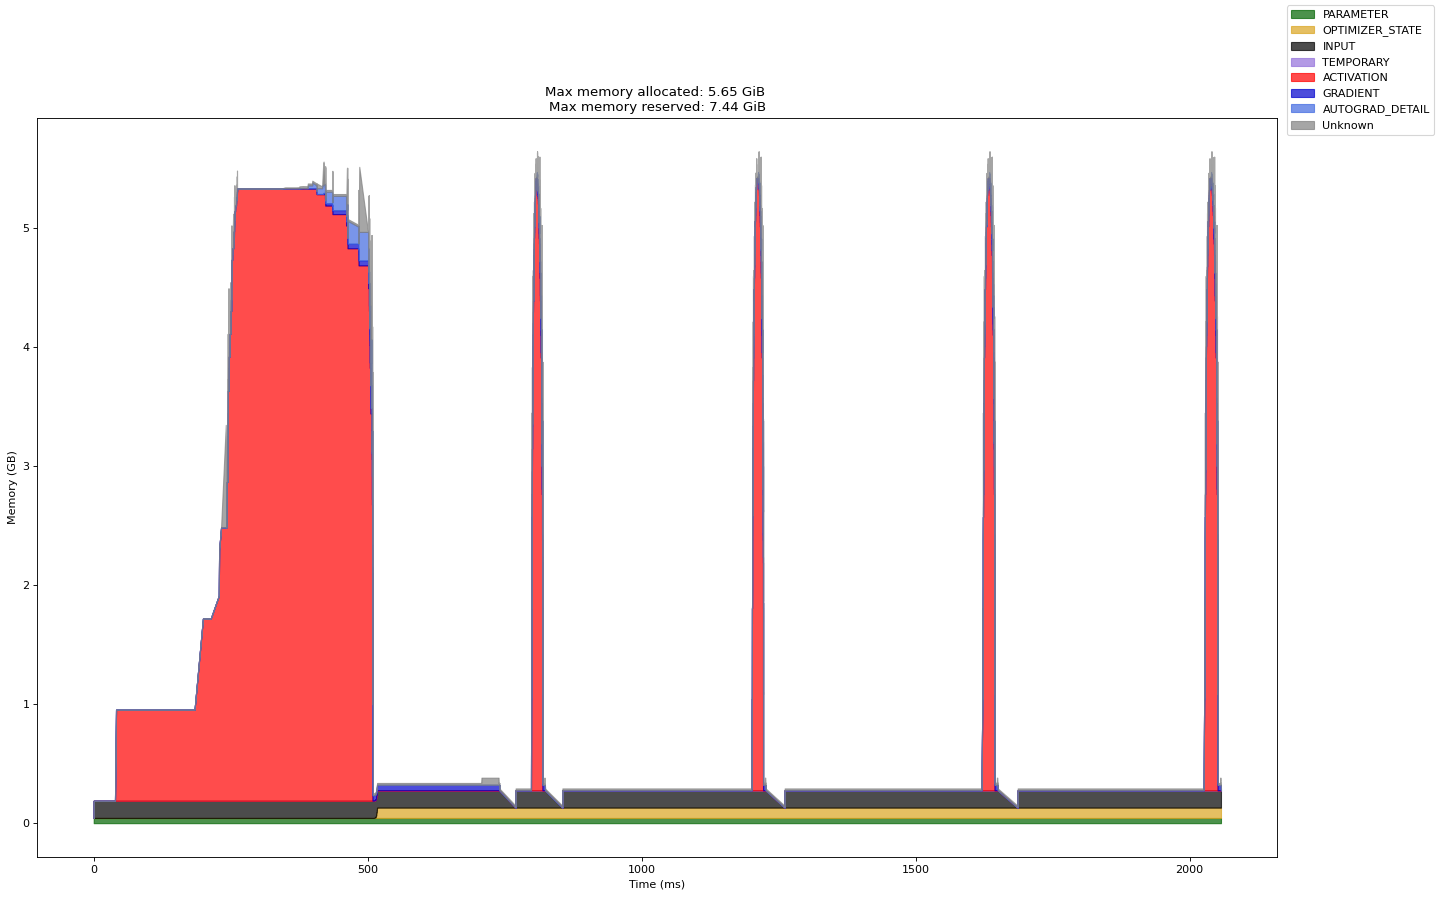

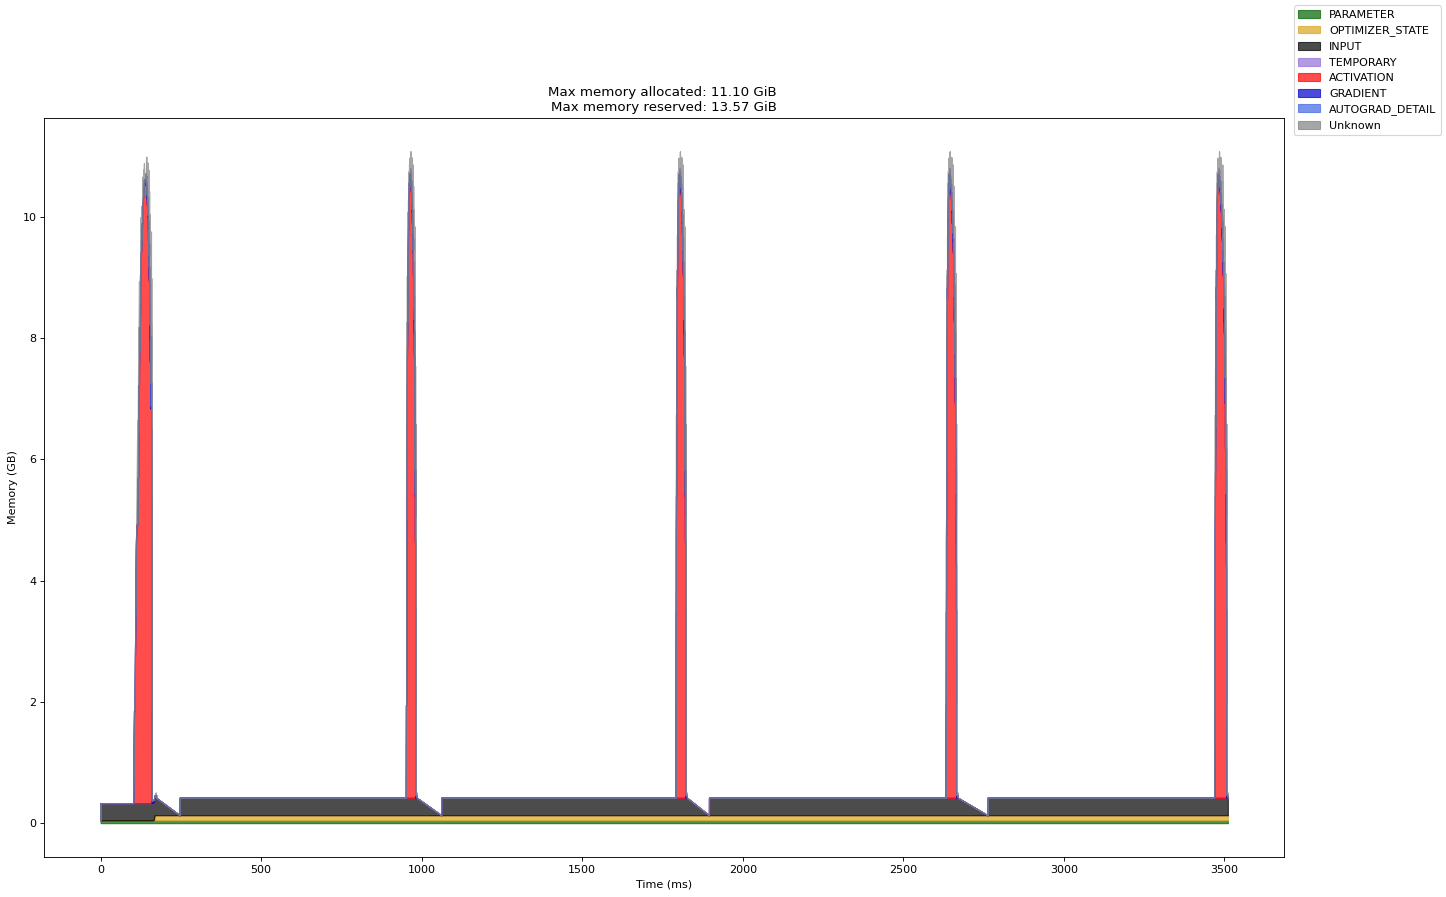

In [9]:
num_workers = 4
break_after_num_batches = 10
batch_indices = None
batch_sizes = [256, 512, 1024, 2048, 4096, 8192]


fit_helper("resnet18_without_checkpointing", tiny_imagenet_torch, 1, break_after_num_batches, title="without_checkpointing")



- Batchsize of 256 seems to take 4GB of memory how ?
- Model takes 44 MB. Activation seems to take the rest. How ?

### Break down memory usage in Resnet
- It takes memory to store the model, activations

In [10]:
from torch.utils.checkpoint import checkpoint_sequential
import torch.nn as nn
import torchvision.models as models

class ResnetCheckpointed(nn.Module):
    def __init__(self):
        super(ResnetCheckpointed, self).__init__()
        self.model = models.resnet18(pretrained=True)
        
        # Create a sequential container for the features
        self.features = nn.Sequential(
            self.model.conv1,
            self.model.bn1,
            self.model.relu,
            self.model.maxpool,
            self.model.layer1,
            self.model.layer2,
            self.model.layer3,
            self.model.layer4,
            self.model.avgpool
        )
        self.fc = self.model.fc
        
        # Number of segments to split the features into for checkpointing
        self.segments = 3

    def forward(self, x):
        # Apply checkpoint_sequential to features
        x = checkpoint_sequential(self.features, self.segments, x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

/root/miniconda3/envs/py3.10/lib/python3.10/site-packages/torch/utils/checkpoint.py:545: UserWarning: torch.utils.checkpoint.checkpoint_sequential: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/root/miniconda3/envs/py3.10/lib/python3.10/site-packages/torch/utils/checkpoint.py:92: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


Proccessed for batch size 256
Allocated memory: 16.25 MB
Cached memory: 318.00 MB
Proccessed for batch size 512
Allocated memory: 16.25 MB
Cached memory: 318.00 MB
Proccessed for batch size 1024
Allocated memory: 16.25 MB
Cached memory: 318.00 MB
Proccessed for batch size 2048
Allocated memory: 16.25 MB
Cached memory: 318.00 MB
Out of memory for batch size 4096
Allocated memory: 16.25 MB
Cached memory: 318.00 MB


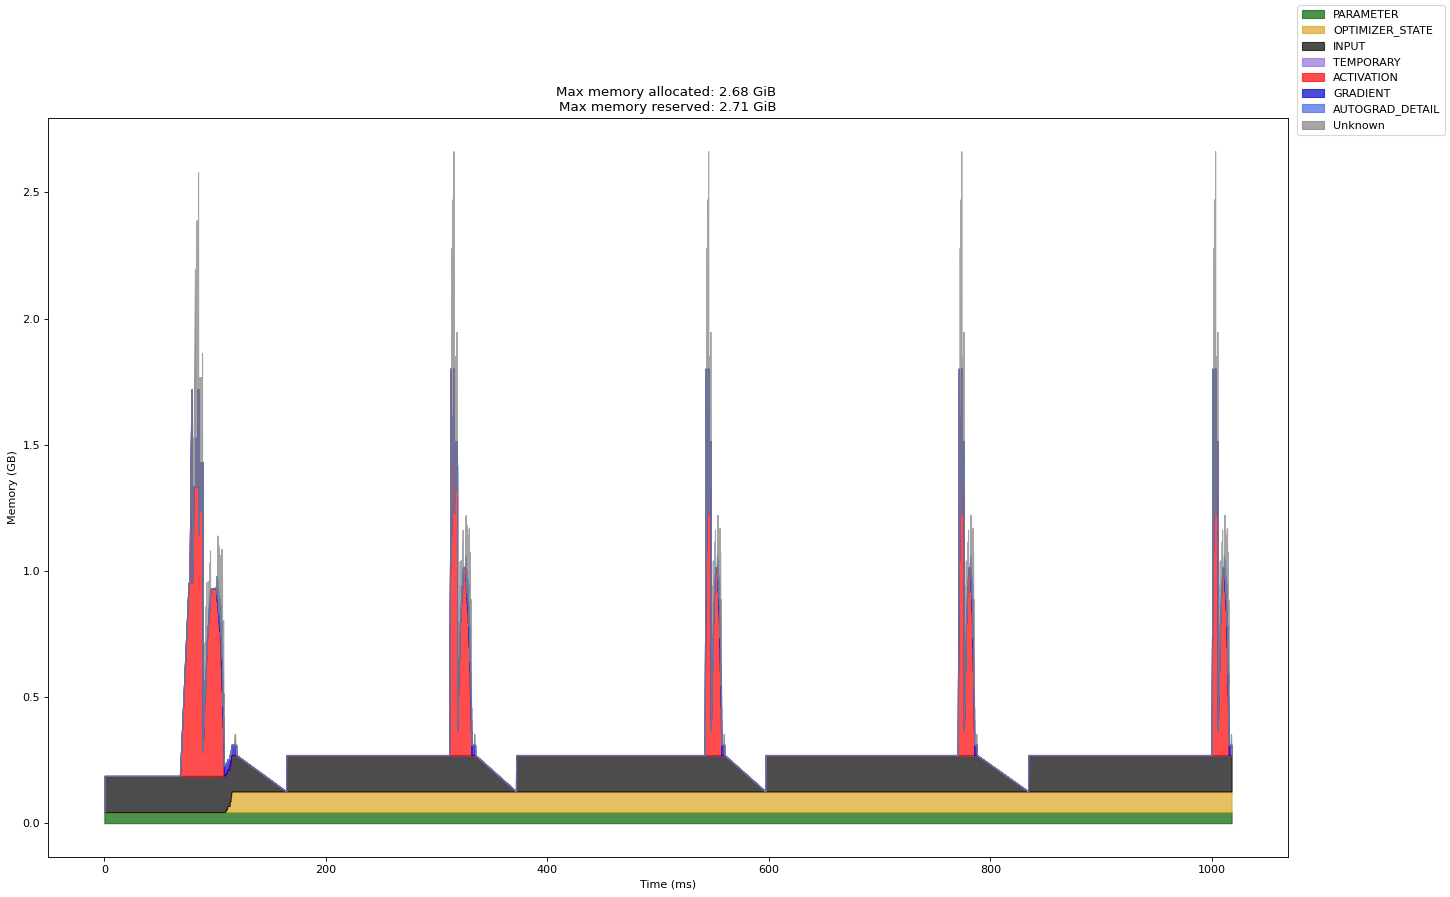

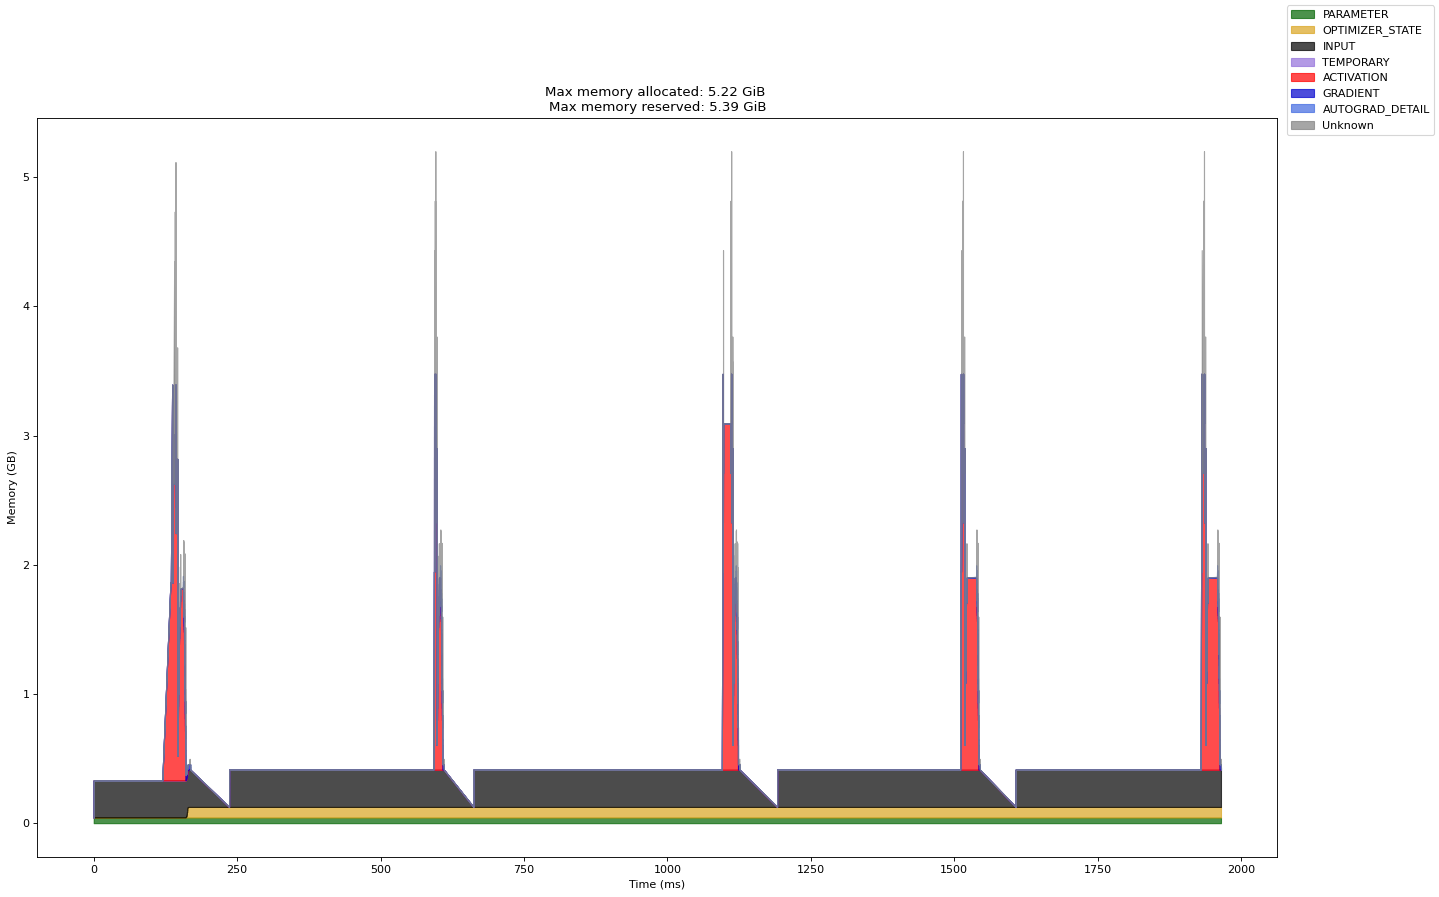

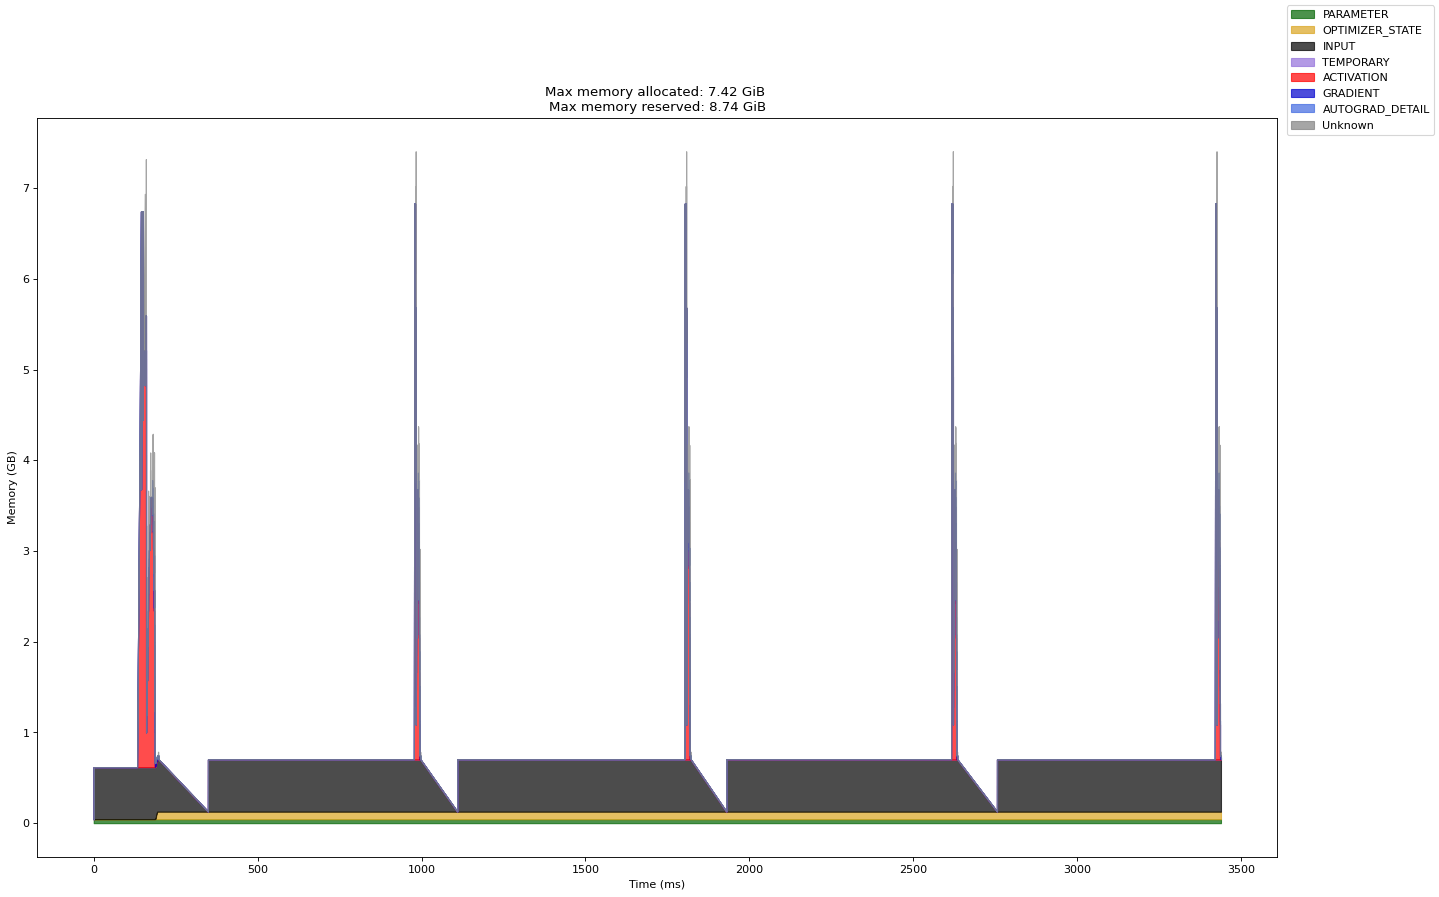

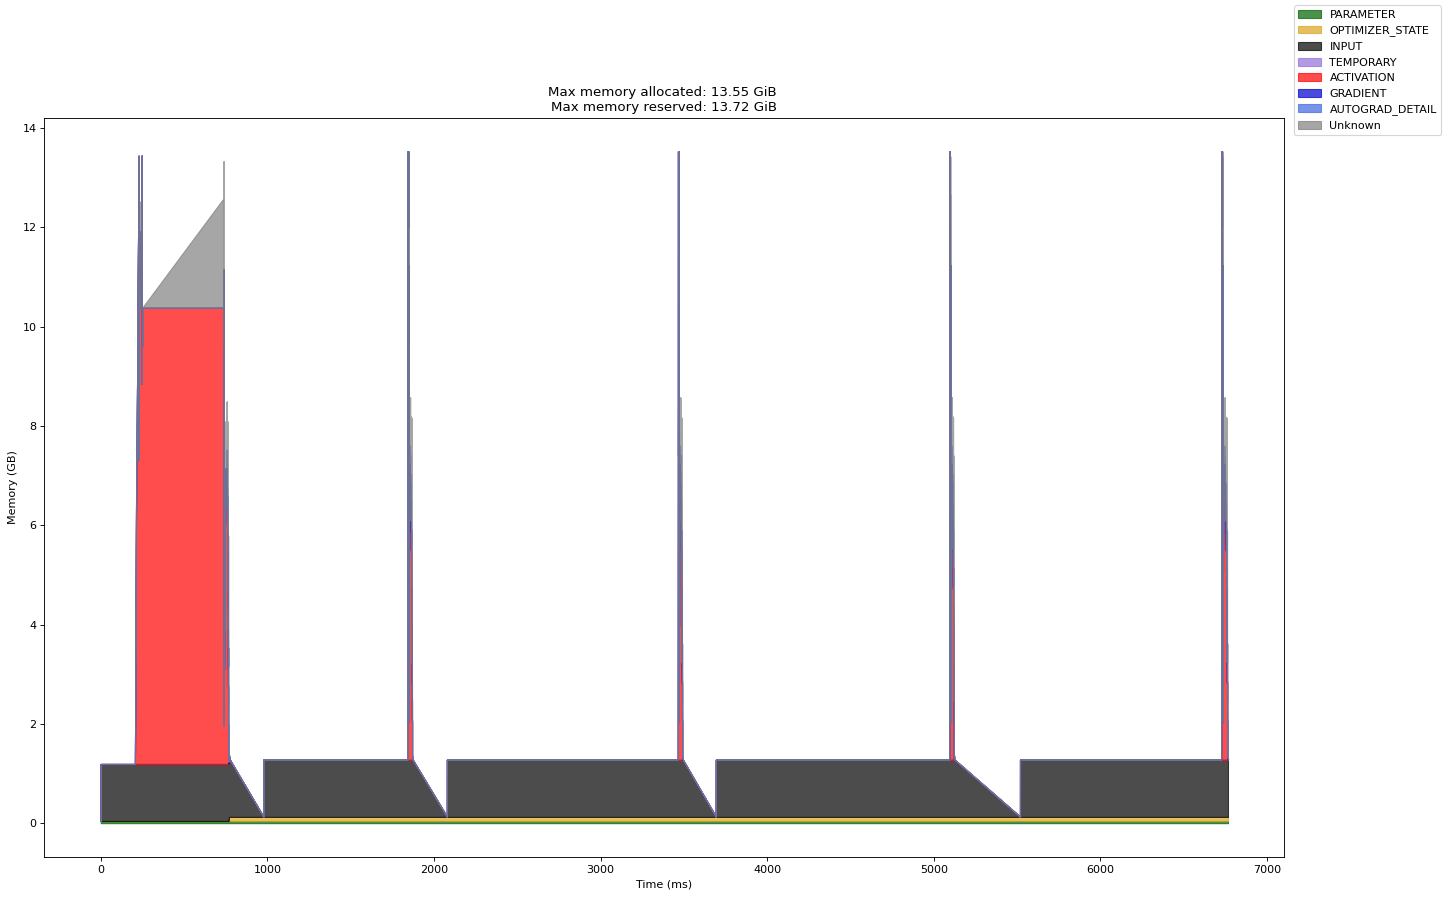

In [11]:
num_workers = 4
break_after_num_batches = 10
batch_indices = None
batch_sizes = [256, 512, 1024, 2048, 4096, 8192]


fit_helper("resnet18_with_checkpointing", tiny_imagenet_torch, 1, break_after_num_batches, title="with_checkpointing")



## Concluding remarks
- Without gradient checkpointing, we were able to fit upto batch size of 1024 in a single GPU 
- With gradient checkpointing, we were able to fit batch sizes of upto 4096 in a single GPU